WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


2021-10-19 11:04:33.240095: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


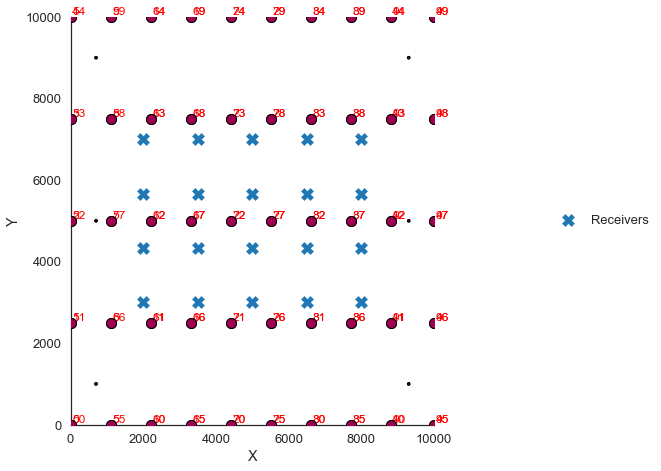

In [1]:

import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
from sys import getsizeof

from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv
sys.path.append('/Users/zhouji/Google Drive/YJ/GP_old')

sys.path.append('/Users/zhouji/Google Drive/YJ/')
import matplotlib.pyplot as plt

import gempy as gp
from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions
import seaborn as sns
from ThreeLayer import *
# %%

# X = [5000]
X = np.linspace(2000,8000,5)
Y = np.linspace(3000,7000,4)

r = []
for x in X:
  for y in Y:
    r.append(np.array([x,y]))
receivers = np.array(r)
Z = 1000
n_devices = receivers.shape[0]

path = '../GP_old/notebooks'
orientation_path = "/data/input_data/George_models/modelx_orientations.csv"
surface_path = '/data/input_data/George_models/'+"modelx2"+'_surface_points.csv'

model = ModelThree(path,surface_path,orientation_path,receivers = receivers,dtype = 'float64')
model.plot_model()
plt.show()

In [2]:
model.geo_data.surfaces

,surface,series,order_surfaces,isActive,color,id,value_0
0,rock1,Strat_Series,1,True,#015482,1,2.500000
1,rock2,Strat_Series,2,True,#9f0052,2,3.500000
2,basement,Basement_Series,1,True,#ffbe00,3,2.500000


## Visualize in 3D

In [3]:
model.activate_regular_grid()
model.scalar_field(model.surface_points_coord)

<tf.Tensor: shape=(300196,), dtype=float64, numpy=
array([0.53105985, 0.53300957, 0.53496038, ..., 0.55788176, 0.55788176,
       0.55788176])>

In [4]:
from gempy.plot.vista import GemPyToVista
import pyvista as pv
gpv = GemPyToVista(model)
gpv.plot_structured_grid('lith',render_topography=False)
gpv.plot_surfaces()


# add receivers to the plot
xyz = np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T

poly = pv.PolyData(xy_ravel)
geom = pv.Cone(direction=[0.0, 0.0, -1.0])

glyphs = poly.glyph(factor=200.0,geom=geom)

gpv.p.add_mesh(glyphs, color="tan",render_points_as_spheres=True,point_size=10)
gpv.set_bounds()

gpv.p.show()

/Users/zhouji/anaconda3/envs/nightly5/lib/python3.7/site-packages/pyvista/plotting/plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


[(-364.88501633822506, -12929.599179979454, 794.9008023112962),
 (5000.0, 5000.0, 550.0),
 (-0.0803051709266898, 0.03763407091699453, 0.9960596147965493)]

In [5]:
# regular grid centers
kernel_centers = np.repeat(model.grid.regular_grid.values[:,:,np.newaxis],n_devices,axis=2)-model.xy_ravel.T
# seperate centers for each receiver
# centers for the first receiver
center1 = kernel_centers[:,:,0]
# reshape for slicing
center1 = center1.reshape([100,100,30,-1])

# get the tz for regular grid
g = GravityPreprocessingRegAll(model,model.grid.regular_grid)
tz = g.set_tz_kernel()
# pick the tz for receiver
tz = tz[:,0]
# reshape tz
tz = tz.reshape([100,100,30,-1])


[0.0, 10000.0, 0.0, 1100.0]


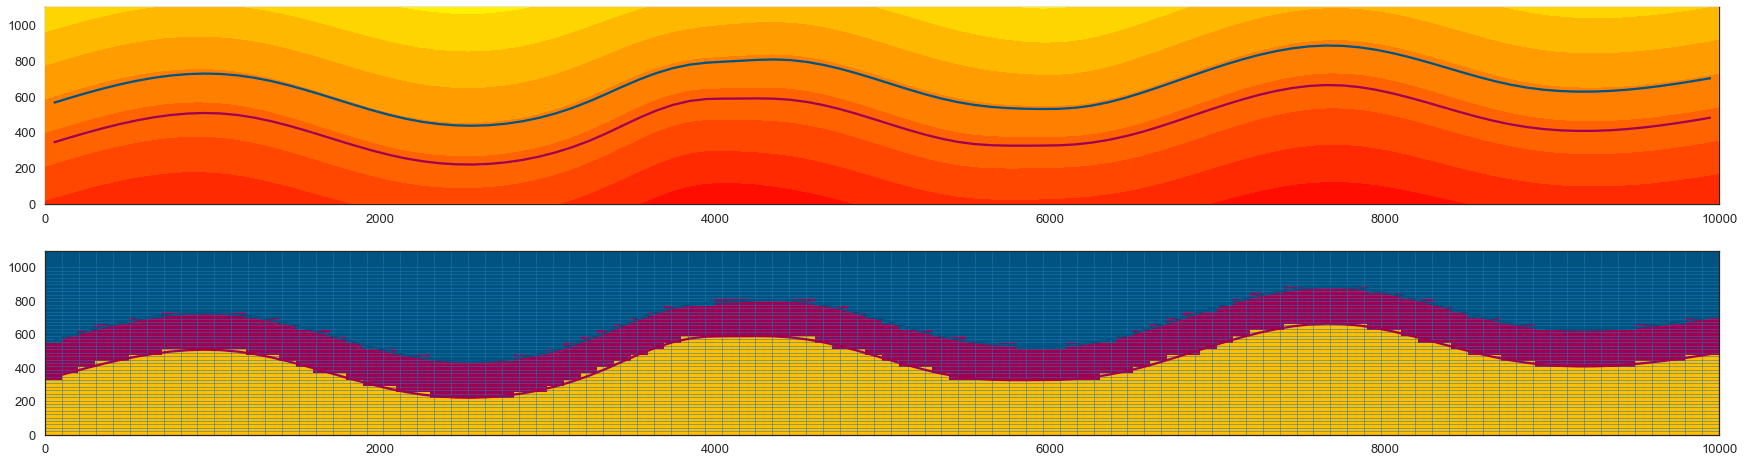

In [6]:
from gempy.plot.visualization_2d_pro import *
fig, ax = plt.subplots(2,1,figsize = (30,8))
ax[0].set_xlim(0,10000)
ax[0].set_ylim(0,1100)
ax[1].set_xlim(0,10000)
ax[1].set_ylim(0,1100)
# ax[2].set_xlim(0,10000)
# ax[2].set_ylim(0,1100)
res = [100,100,50]

p = Plot2D(model)
p.plot_scalar_field(ax[0],cell_number=50)
p.plot_contacts(ax[0],cell_number=50)

p.plot_lith(ax[1],cell_number=50)
p.plot_contacts(ax[1],cell_number=50)

v_lines = np.linspace(0,10000,100)
for v in v_lines:
    ax[1].axvline(x = v,linewidth = 0.5)
h_lines = np.linspace(0,1000,50)
for h in h_lines:
    ax[1].axhline(y = h,linewidth = 0.5)

# ax[1].plot(4500,1000,marker = 7,c='r',markersize = 15,label = 'Receiver')
# ax[1].axhline(y = 1000,linewidth = 4, color = 'k',alpha = 0.7)
# ax[1].quiver(center1[:,47,:,0],center1[:,47,:,2],0,-1, -tz[:,47,:],scale=1e-9,width = 0.0003,headwidth = 4,headlength=1,alpha=0.7)
# ax[1].quiver(center1[:,47,:,0]+4500,center1[:,47,:,2]+1000,0,-1, -tz[:,47,:],scale=1e-10,width = 0.003,headwidth = 4,headlength=1,alpha=0.7)
# plt.savefig('./threelayer_scalar_field.png',bbox_inches='tight',pad_inches = 0)
plt.show()


In [7]:
# plt.imshow(np.squeeze(-tz[:,48,:].T),origin= 'lower')
# plt.colorbar()

In [8]:
# fig, ax = plt.subplots(figsize = (10,3))
# ax.set_xlim(0,10000)
# ax.set_ylim(0,1100)
# ax = p.plot_lith(ax,cell_number=50)
# plt.gca().set_axis_off()
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.savefig('./three_layer_2d.png',bbox_inches='tight',pad_inches = 0,dpi = 1000)

## Only Centered grid activate here

In [9]:
model.activate_centered_grid()

Compute the gravity

In [10]:
res  = [30, 30, 30]
kernel_centers = model.geo_data.grid.centered_grid.kernel_centers
kernel_dxyz_left = model.geo_data.grid.centered_grid.kernel_dxyz_left
kernel_dxyz_right = model.geo_data.grid.centered_grid.kernel_dxyz_right
a, b, c = kernel_centers, kernel_dxyz_left, kernel_dxyz_right
heights = np.abs(b[:, 2].reshape(res) + c[:, 2].reshape(res))
width_x = (b+c)[:,0].reshape(res)
width_y = (b+c)[:,1].reshape(res)

ValueError: cannot reshape array of size 132651 into shape (30,30,30)

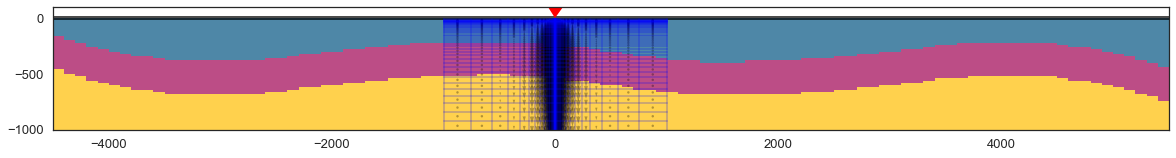

In [ ]:
from PIL import Image
img1 = Image.open('./three_layer_2d.png')

tz = model.tz.numpy()

centered_grid = model.grid.centered_grid
slice= None
resolution=res
slice = 1
a, b, c = centered_grid.kernel_centers, centered_grid.kernel_dxyz_left, \
          centered_grid.kernel_dxyz_right

res = np.array(resolution)
if slice is None:
  slice = int(res[1]/2)

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

ax.imshow(img1, alpha=0.7,extent = (-4500,5500,-1000,0))

# plot the ground surface at 0
ax.axhline(y = 0,linewidth = 4, color = 'k',alpha = 0.7)

for xc in (a[:, 0].reshape(res)[slice, :, slice].ravel() -
              b[:, 0].reshape(res)[slice, :, slice].ravel()):
              ax.axvline(x = xc,ymin = 0,ymax=0.9 , linewidth = 2, color = 'b',alpha = 0.2)

ax.axvline(x = (a+b)[:, 0].reshape(res)[slice, -1, slice].ravel(),ymin = 0,ymax=0.9,linewidth = 2, color = 'b',alpha = 0.2)

for yc in (a[:, 2].reshape(res)[slice, slice, :].ravel() -
              b[:, 2].reshape(res)[slice, slice, :].ravel()):
              ax.axhline(y = yc,xmin = 0.35,xmax = .55, linewidth = 2, color = 'b',alpha = 0.2)


x  = a[:, 0].reshape(res)[slice, :, :].ravel()
y  = a[:, 2].reshape(res)[:, slice, :].ravel()


# ax.scatter(x,y,c ='cornflowerblue',marker = '.', label = 'Centers')

height = np.abs(b[:, 2].reshape(res)[:, slice,:].ravel() + c[:, 2].reshape(res)[slice, :, :].ravel())
width = b[:, 0].reshape(res)[slice, :, :].ravel()+c[:, 0].reshape(res)[slice, :, :].ravel()

ax.quiver(x,
            y,
            np.zeros(res[0]*res[2]),
            tz.reshape(res)[slice, :, :].ravel()/(width*width*height), label='$t_z$', alpha=.3,
          scale=2e-6
            )


ax.plot(0,0,marker = 7,c='r',markersize = 15,label = 'Receiver')
ax.set_xlim(-4500, 5500)
ax.set_ylim(-1000, 100)

# ax.legend(loc  = 'lower right',edgecolor = 'k',borderpad=1,labelspacing=1.5,frameon = True,fancybox=False,shadow=False)

# plt.savefig('./threelayer_center_2d.png',bbox_inches='tight',pad_inches = 0,dpi = 1000)
plt.show()

The width of the cells grows exponentially 

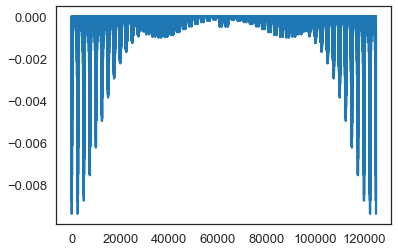

In [ ]:
plt.plot(tz)

In [ ]:
print(round(getsizeof(model.tz.numpy())/1024/1024,2),'MB')

0.95 MB


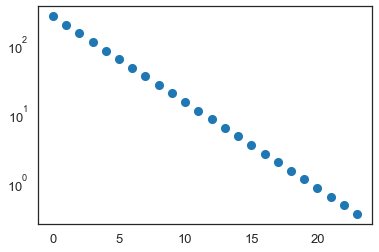

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line, = ax.plot((kernel_dxyz_left[:int((res[0]/2)*res[2]):50,0]*2)[:-1],'o')

ax.set_yscale('log')

In [ ]:
a = (kernel_dxyz_left[:int((res[0]/2)*res[2]):50,0]*2)[::-1]
np.cumsum(a)

array([1.00000000e+00, 1.33352143e+00, 1.77827941e+00, 2.37137371e+00,
       3.16227766e+00, 4.21696503e+00, 5.62341325e+00, 7.49894209e+00,
       1.00000000e+01, 1.33352143e+01, 1.77827941e+01, 2.37137371e+01,
       3.16227766e+01, 4.21696503e+01, 5.62341325e+01, 7.49894209e+01,
       1.00000000e+02, 1.33352143e+02, 1.77827941e+02, 2.37137371e+02,
       3.16227766e+02, 4.21696503e+02, 5.62341325e+02, 7.49894209e+02,
       1.00000000e+03])

In the range of 500m,  the avarage cell width is 30m

In [ ]:
avg_cell_centered = np.mean(a[:17])
print(avg_cell_centered)

5.882352941176471


To reach such a cell width in a centered regular grid, requires 100 by 100 resolution, centered grid only about 40% portion of the resolution on each dimension, which saves in total about 90% cells

In [ ]:
#number of centered regular grid needed
6000/avg_cell_centered

1019.9999999999999

In [ ]:
#number of all regular grid needed
10000/avg_cell_centered

1699.9999999999998

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# tz = model.tz.numpy()
# centers_centergrid = model.geo_data.grid.centered_grid.kernel_centers
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2], '.', alpha=.2,s=10)

# ax.scatter(np.array([[0, 0, 0]])[:, 0],
#            np.array([[0, 0, 0]])[:, 1],
#            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=100)

# ax.quiver(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2],0,0, tz, length=5000,arrow_length_ratio=0.3)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

If we normalize the arrows by the volumn of the cell

In [ ]:

# from mpl_toolkits.mplot3d import Axes3D
# centers_centergrid = model.geo_data.grid.centered_grid.kernel_centers
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2], '.', alpha=.2,s=10)

# # center position
# ax.scatter(np.array([[0, 0, 0]])[:, 0],
#            np.array([[0, 0, 0]])[:, 1],
#            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=30)

# new_tz = (tz.reshape(res)/(width_x*width_y*heights)).ravel()
# ax.quiver(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2],0,0, new_tz, length=1e8,arrow_length_ratio=0.05,alpha = 0.3,normalize=False)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

In [ ]:
#normalized Tz
# plt.plot(new_tz)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-68.22202825, -68.23341376, -68.23294393, -68.21812107,
       -68.19620667, -68.17547533, -68.16574561, -68.1744337 ,
       -68.20279619, -68.24498031])>

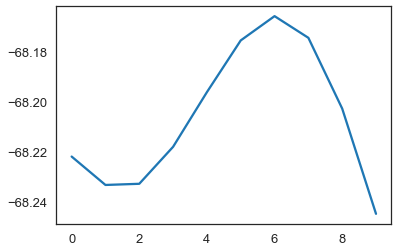

In [ ]:
grav_centered = model.calculate_grav(model.surface_points_coord,model.values_properties)
plt.plot(grav_centered)
grav_centered

In [ ]:
surface_coord = model.surface_points_coord
values_properties = model.values_properties
model.TFG = TFGraph(model.dip_angles, model.azimuth,
    model.polarity, model.fault_drift,
    model.grid_tensor, model.values_properties, model.len_rest_form, model.Range,
    model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
    model.rescale_factor,dtype = model.tfdtype)
Z_x = model.TFG.scalar_field(surface_coord,model.dips_position)
scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)

# formations_block = model.TFG.export_formation_block(
#     Z_x, scalar_field_at_surface_points, values_properties)

In [ ]:
model.TFG.sig_slope

<tf.Tensor: shape=(), dtype=float64, numpy=500.0>

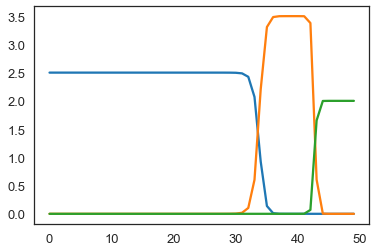

In [ ]:
slope = 1000
scalar_field_iter = tf.pad(tf.expand_dims(
    scalar_field_at_surface_points, 0), [[0, 0], [1, 1]])[0]

n_surface_op_float_sigmoid_mask = tf.repeat(
    values_properties, 2, axis=1)
n_surface_op_float_sigmoid = tf.pad(
    n_surface_op_float_sigmoid_mask[:, 1:-1], [[0, 0], [1, 1]])
drift = tf.pad(
    n_surface_op_float_sigmoid_mask[:, 0:-1], [[0, 0], [0, 1]])
formations_block = tf.zeros([1, tf.shape(Z_x)[0]], dtype=model.TFG.dtype)

# need to check if Hessian works for this, otherwise vectorize
# code for vectorization
# tf.concat([tf.expand_dims(tf.range(scalar_field_iter.shape[1]-1),1),
# tf.expand_dims(tf.range(scalar_field_iter.shape[1]-1)+1,1)],-1)

# for i in range(model.TFG.number_of_series+2):
for i in range(3):
## tensorflow autograph trick, only with this loop set to concret shape, second order derivative can work properly in graph mode
    tf.autograph.experimental.set_loop_options(
        shape_invariants=[(formations_block, tf.TensorShape([None, Z_x.shape[0]]))])

    formations_block = formations_block + \
        model.TFG.compare(scalar_field_iter[i], scalar_field_iter[i + 1],
                        2 * i, Z_x, slope, n_surface_op_float_sigmoid, drift)
    plt.plot(model.TFG.compare(scalar_field_iter[i], scalar_field_iter[i + 1],
                        2 * i, Z_x, slope, n_surface_op_float_sigmoid, drift)[1][:50])

# if model.TFG.gradient is True:
#     ReLU_up = - 0.01 * tf.nn.relu(Z_x - scalar_field_iter[1])
#     ReLU_down = 0.01 * tf.nn.relu(Z_x - scalar_field_iter[-2])

#     formations_block += ReLU_down + ReLU_up

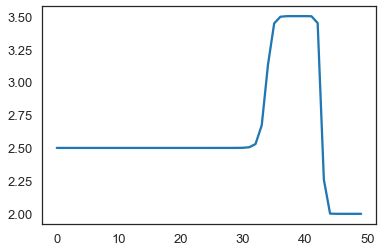

In [ ]:
plt.plot(formations_block[1][:50])

In [ ]:
model.geo_data.surfaces

,surface,series,order_surfaces,isActive,color,id,value_0
0,rock1,Strat_Series,1,True,#015482,1,2.5
1,rock2,Strat_Series,2,True,#9f0052,2,3.5
2,basement,Basement_Series,1,True,#ffbe00,3,2


In [ ]:
scalar_field_iter

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.        , 1.17675001, 1.14665642, 0.        ])>

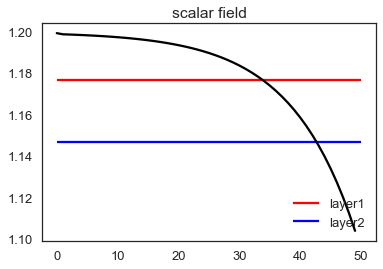

In [ ]:
plt.plot(Z_x[:50],c='k')
plt.hlines(scalar_field_iter[1],0,50,colors='r',label='layer1')
plt.hlines(scalar_field_iter[2],0,50,colors='b',label='layer2')
plt.title('scalar field')
plt.legend(loc = 'lower right')

## Gravity on Regular Grid

Let's try use all regular grids, because the regular grids are not centered abour a receiver, individual tz matrix are required for each receiver.

In [ ]:
model.activate_regular_grid()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
model.scalar_field(model.surface_points_coord)
g = GravityPreprocessingRegAll(model,model.grid.regular_grid)
tz = g.set_tz_kernel()

res = [100, 100, 50]
size = reduce((lambda x, y: x * y), res)

Memory usage of Tz

In [ ]:
print(round(getsizeof(tz/n_devices)/1024/1024,2),'MB')

38.15 MB


In [ ]:
surface_coord = model.surface_points_coord
values_properties = model.values_properties
model.TFG = TFGraph(model.dip_angles, model.azimuth,
        model.polarity, model.fault_drift,
        model.grid_tensor, model.values_properties, model.len_rest_form, model.Range,
        model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
        model.rescale_factor,dtype = model.tfdtype)
Z_x = model.TFG.scalar_field(surface_coord,model.dips_position)

scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)
# formations_block = model.TFG.export_formation_block(
#     Z_x, scalar_field_at_surface_points, model.values_properties)
formations_block = model.TFG.export_formation_block(
    Z_x, scalar_field_at_surface_points, values_properties)

densities = formations_block[1][:size]
# densities = formations_block[1][model.lg_0:model.lg_1]

In [ ]:
kernel_centers = np.repeat(model.grid.regular_grid.values[:,:,np.newaxis],n_devices,axis=2)-model.xy_ravel.T

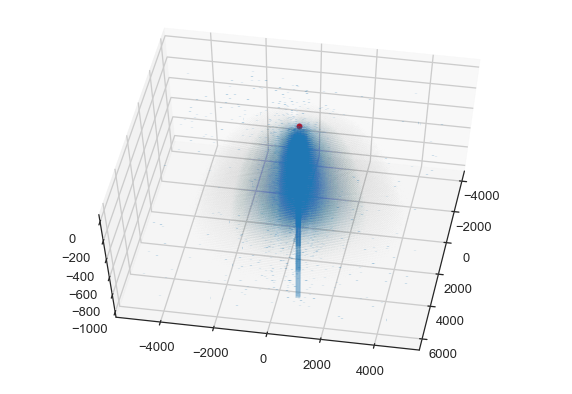

In [ ]:
# 3D plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
center1 = kernel_centers[:,:,0]

# ax.scatter(center1[:size, 0], center1[:size, 1], center1[:size, 2], '.', alpha=.2,s=10)

ax.scatter(np.array([[0, 0, 0]])[:, 0],
           np.array([[0, 0, 0]])[:, 1],
           np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=30)

# ax.quiver(center1[:size, 0], center1[:size, 1], center1[:size, 2], -center1[:size, 0], -center1[:size, 1], -center1[:size, 2], length=0.1,alpha=0.01)

ax.quiver(center1[:size, 0], center1[:size, 1], center1[:size, 2],0,0, tz[:,0], length=1e4,alpha=0.1)
ax.view_init(elev=60, azim=10)

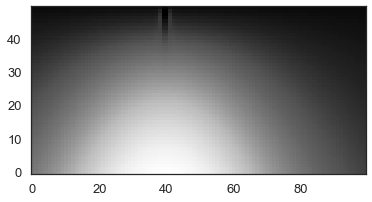

In [ ]:
plt.imshow(tz[:,0].reshape((100,100,50))[:,10,:].T,origin='lower')

In [ ]:
densities_tile = tf.repeat(tf.reshape(densities,[-1,1]),[n_devices],axis=1)
grav_regular = tf.reduce_sum(densities_tile*tz, axis=0)

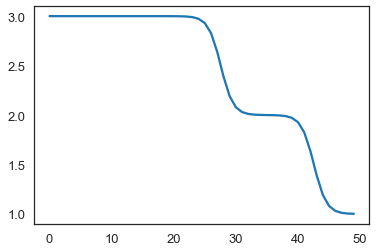

In [ ]:
plt.plot(formations_block[0][:50])

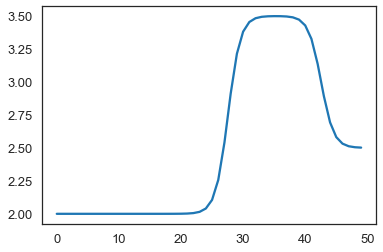

In [ ]:
plt.plot(formations_block[1][:50])

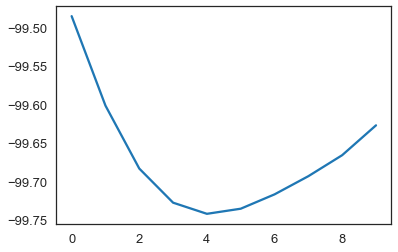

In [ ]:
plt.plot(grav_regular)

# Regular grid in range

In [ ]:
from gempy.core.grid_modules.grid_types import CenteredGrid

In [ ]:
class CenteredRegGrid(CenteredGrid):
    """
    linear spaced centered grid.
    """
    @staticmethod
    def create_irregular_grid_kernel(resolution, radius):
        """
        Create an isometric grid kernel (centered at 0)

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:
            tuple: center of the voxel, left edge of each voxel (for xyz), right edge of each voxel (for xyz).
        """

        if radius is not list or radius is not np.ndarray:
            radius = np.repeat(radius, 3)

        g_ = []
        g_2 = [] # contains exp coord, left right xy, top and bottom
        d_ = []
        for xyz in [0, 1, 2]:

            if xyz == 2:
                # Make the grid only negative for the z axis

                g_.append(np.linspace(0.0001, 1, int(resolution[xyz])))
                g_2.append(
                    (np.concatenate(([0], g_[xyz])) + 0.0001) * - radius[xyz])
            else:
                g_.append(np.linspace(0.0001, 1, int(resolution[xyz] / 2)+1))
                g_2.append(
                    np.concatenate((-g_[xyz][::-1], g_[xyz][1:])) * radius[xyz])
        
        #my modification below, change the left/right boundary to grow exponentally instead of the center point
        
        x_center = (g_2[0][:-1]+g_2[0][1:])/2 
        y_center = (g_2[1][:-1]+g_2[1][1:])/2
        z_center = (g_2[-1][:-1]+g_2[-1][1:])/2
        g = np.meshgrid(x_center,y_center,z_center)
        
        d_left_x = np.abs(g_2[0][:-1] - x_center)
        d_left_y = np.abs(g_2[1][:-1] - y_center)
        d_right_x = np.abs(g_2[0][1:] - x_center)
        d_right_y = np.abs(g_2[1][1:] - y_center)
        d_z = z_center - g_2[-1][:-1]
        
        d_left = np.meshgrid(d_left_x,d_left_y,d_z)
        d_right = np.meshgrid(d_right_x,d_right_y,d_z)
    
        kernel_g = np.vstack(tuple(map(np.ravel, g))).T.astype("float64")
        kernel_d_left = np.vstack(tuple(map(np.ravel, d_left))).T.astype("float64")
        kernel_d_right = np.vstack(tuple(map(np.ravel, d_right))).T.astype("float64")

        print('yes')
        return kernel_g, kernel_d_left, kernel_d_right


In [ ]:
res = [70,70,50]
centerReg = CenteredRegGrid(model.xy_ravel,radius=1000,resolution=res)
size = reduce((lambda x, y: x * y), res)

yes


In [ ]:
tz = centerReg.set_tz_kernel()

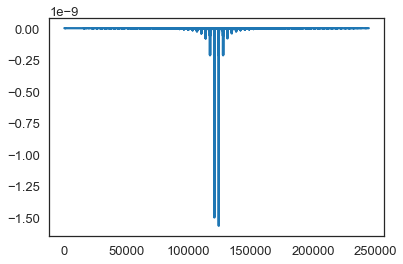

In [ ]:
plt.plot(tz)

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# centers_centergrid = centerReg.kernel_centers
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(centers_centergrid[:, 0], centers_centergrid[:, 1], centers_centergrid[:, 2], '.', alpha=.2,s=10)

# # ax.scatter(np.array([[0, 0, 0]])[:, 0],
# #            np.array([[0, 0, 0]])[:, 1],
# #            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=100)

# ax.quiver(centers_centergrid[:size, 0], centers_centergrid[:size, 1], centers_centergrid[:size, 2],0,0, tz, length=1e11,alpha=0.3)
# ax.view_init(elev=30., azim=45)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

In [ ]:

grid_values = centerReg.kernel_centers

s_gr_x = grid_values[:, 0]
s_gr_y = grid_values[:, 1]
s_gr_z = grid_values[:, 2]

# getting the coordinates of the corners of the voxel...
x_cor = np.stack((s_gr_x - centerReg.kernel_dxyz_left[:, 0],
                    s_gr_x + centerReg.kernel_dxyz_right[:, 0]), axis=1)
y_cor = np.stack((s_gr_y - centerReg.kernel_dxyz_left[:, 1],
                    s_gr_y + centerReg.kernel_dxyz_right[:, 1]), axis=1)
z_cor = np.stack((s_gr_z - centerReg.kernel_dxyz_left[:, 2],
                    s_gr_z + centerReg.kernel_dxyz_right[:, 2]), axis=1)

# ...and prepare them for a vectorial op
x_matrix = np.repeat(x_cor, 4, axis=1)
y_matrix = np.tile(np.repeat(y_cor, 2, axis=1), (1, 2))
z_matrix = np.tile(z_cor, (1, 4))

s_r = np.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

# This is the vector that determines the sign of the corner of the voxel
mu = np.array([1, -1, -1, 1, -1, 1, 1, -1])

G = 6.674e-3

centerReg.tz = (
    np.sum(- 1 *
            G *
            mu * (
                    x_matrix * np.log(y_matrix + s_r) +
                    y_matrix * np.log(x_matrix + s_r) -
                    z_matrix * np.arctan(
                x_matrix * y_matrix / (z_matrix * s_r))),
            axis=1))


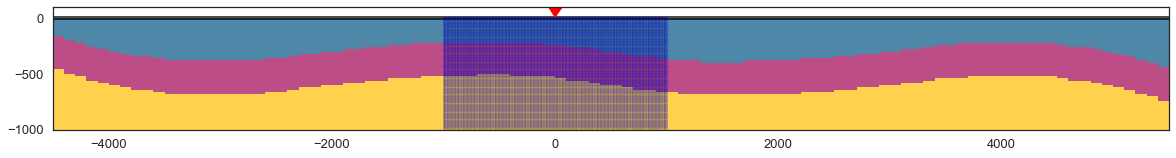

In [ ]:
from PIL import Image
img1 = Image.open('./three_layer_2d.png')

tz = centerReg.set_tz_kernel()

# centerReg = model.grid.centered_grid
slice= None
resolution=res
slice = 1
a, b, c = centerReg.kernel_centers, centerReg.kernel_dxyz_left, \
          centerReg.kernel_dxyz_right

res = np.array(resolution)
if slice is None:
  slice = int(res[1]/2)

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

ax.imshow(img1, alpha=0.7,extent = (-4500,5500,-1000,0))

# plot the ground surface at 0
ax.axhline(y = 0,linewidth = 4, color = 'k',alpha = 0.7)

for xc in (a[:, 0].reshape(res)[slice, :, slice].ravel() -
              b[:, 0].reshape(res)[slice, :, slice].ravel()):
              ax.axvline(x = xc,ymin = 0,ymax=0.9 , linewidth = 2, color = 'b',alpha = 0.2)

ax.axvline(x = (a+b)[:, 0].reshape(res)[slice, -1, slice].ravel(),ymin = 0,ymax=0.9,linewidth = 2, color = 'b',alpha = 0.2)

for yc in (a[:, 2].reshape(res)[slice, slice, :].ravel() -
              b[:, 2].reshape(res)[slice, slice, :].ravel()):
              ax.axhline(y = yc,xmin = 0.35,xmax = .55, linewidth = 2, color = 'b',alpha = 0.2)


x  = a[:, 0].reshape(res)[slice, :, :].ravel()
y  = a[:, 2].reshape(res)[:, slice, :].ravel()


# ax.scatter(x,y,c ='cornflowerblue',marker = '.', label = 'Centers')

height = np.abs(b[:, 2].reshape(res)[:, slice,:].ravel() + c[:, 2].reshape(res)[slice, :, :].ravel())
width = b[:, 0].reshape(res)[slice, :, :].ravel()+c[:, 0].reshape(res)[slice, :, :].ravel()

ax.quiver(x,
            y,
            np.zeros(res[0]*res[2]),
            tz.reshape(res)[slice, :, :].ravel()/(width*width*height), label='$t_z$', alpha=.3,
          scale=2e-6
            )


ax.plot(0,0,marker = 7,c='r',markersize = 15,label = 'Receiver')
ax.set_xlim(-4500, 5500)
ax.set_ylim(-1000, 100)

# ax.legend(loc  = 'lower right',edgecolor = 'k',borderpad=1,labelspacing=1.5,frameon = True,fancybox=False,shadow=False)

plt.savefig('./threelayer_centerregular_2d.png',bbox_inches='tight',pad_inches = 0,dpi = 1000)
plt.show()

In [ ]:
centerReg.tz.shape[0]

245000

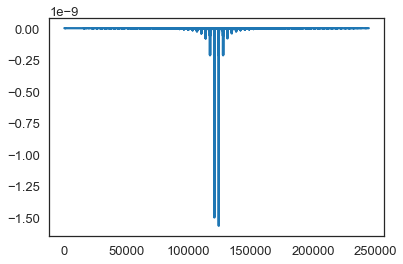

In [ ]:
plt.plot(centerReg.tz)

In [ ]:
print(round(getsizeof(centerReg.tz)/1024/1024,2),'MB')

1.87 MB


In [ ]:
model.geo_data.grid.custom_grid=centerReg
size = centerReg.values.shape[0]

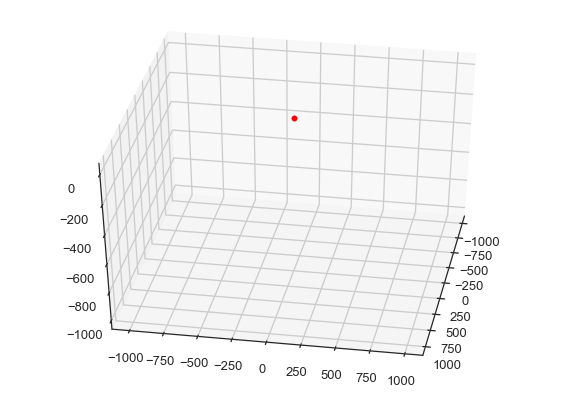

In [ ]:
# fig = plt.figure(figsize=(10,7))
# ax = fig.add_subplot(111, projection='3d')
# center1 = centerReg.kernel_centers

# # ax.scatter(center1[:size, 0], center1[:size, 1], center1[:size, 2], '.', alpha=.2,s=10)

# ax.scatter(np.array([[0, 0, 0]])[:, 0],
#            np.array([[0, 0, 0]])[:, 1],
#            np.array([[0, 0, 0]])[:, 2], c='r', alpha=1, s=30)

# # ax.quiver(center1[:size, 0], center1[:size, 1], center1[:size, 2], -center1[:size, 0], -center1[:size, 1], -center1[:size, 2], length=0.1,alpha=0.01)

# ax.quiver(center1[:size, 0], center1[:size, 1], center1[:size, 2],0,0, centerReg.tz, length=1e4,alpha=0.1)
# ax.view_init(elev=40., azim=10)

In [ ]:
model.geo_data.grid.deactivate_all_grids()
# activate also rescaled the grid
model.geo_data.grid.set_active('custom')

array([False,  True, False, False, False])

In [ ]:
model.geo_data.rescaling.set_rescaled_grid()

In [ ]:
grid_tensor = model.geo_data.grid.values_r
model.from_gempy_interpolator()

In [ ]:
fault_drift = np.zeros((0, model.grid.values.shape[0] ))

In [ ]:
fault_drift = fault_drift[:,:size]
fault_drift.shape

(0, 2450000)

In [ ]:
model.TFG = TFGraph(model.dip_angles, model.azimuth,model.polarity, fault_drift,
grid_tensor, model.values_properties, model.len_rest_form, model.Range,
model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
model.rescale_factor,dtype = model.tfdtype)
Z_x = model.TFG.scalar_field(surface_coord,model.dips_position)

scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)
# formations_block = model.TFG.export_formation_block(
#     Z_x, scalar_field_at_surface_points, model.values_properties)
formations_block = model.TFG.export_formation_block(
    Z_x, scalar_field_at_surface_points, values_properties)

# densities = formations_block[1][model.lg_0:model.lg_1]
densities = formations_block[1][:size]

gravity_center_reg = model.TFG.compute_forward_gravity(centerReg.tz, 0, size, densities)


In [ ]:
values_properties

<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[1. , 2. , 3. ],
       [2.5, 3.5, 2. ]])>

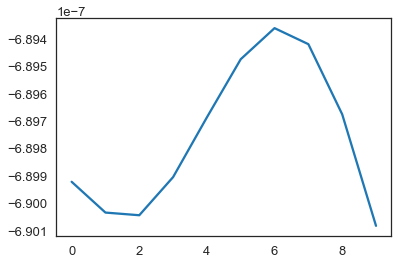

In [ ]:
plt.plot(gravity_center_reg)

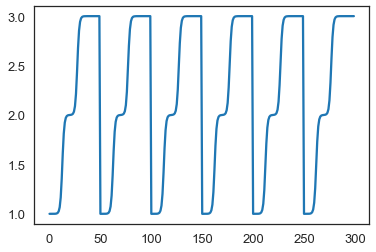

In [ ]:
plt.plot(formations_block[0][:300])

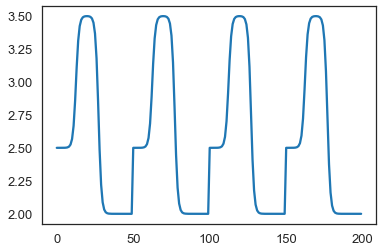

In [ ]:
plt.plot(densities[:200])

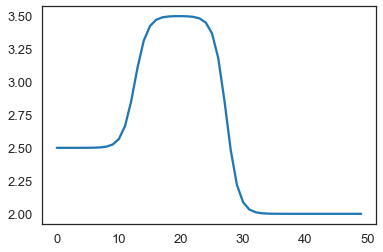

In [ ]:
f = formations_block[1][:size]
plt.plot(f[:50])


In [ ]:
grav_regular_norm = grav_regular - min(grav_regular)
grav_centered_norm = grav_centered - min(grav_centered)
gravity_center_reg_norm = gravity_center_reg - min(gravity_center_reg)

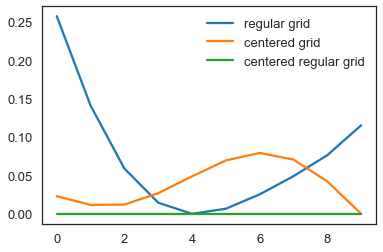

In [ ]:
plt.plot(grav_regular_norm, label = 'regular grid')
plt.plot(grav_centered_norm, label = 'centered grid')
plt.plot(gravity_center_reg_norm, label = 'centered regular grid')
plt.legend()

In [ ]:
min(grav_regular)

<tf.Tensor: shape=(), dtype=float64, numpy=-99.74237576950277>